In [128]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
np.random.seed(123)
df4 = pd.read_csv('homework4.csv')
df4['d'] = df4['d'].astype(int)

# Problem 1

In [146]:
def bootstrap_confidence_interval(data, stat_function, alpha=0.05, n_bootstraps=200, seed=None):
    if seed is not None:
        np.random.seed(seed)
    bootstrapped_statistics = []
    for _ in range(n_bootstraps):
        resampled_data = resample(data)
        stat = stat_function(resampled_data)
        bootstrapped_statistics.append(stat)
    lower = np.percentile(bootstrapped_statistics, 100 * alpha / 2)
    upper = np.percentile(bootstrapped_statistics, 100 * (1 - alpha / 2))
    return np.mean(bootstrapped_statistics), lower, upper, bootstrapped_statistics

def estimate_ate_estimator0(data):
    treated = data[data['d'] == 1]
    control = data[data['d'] == 0]
    return treated['y'].mean() - control['y'].mean()

def estimate_ate_estimator1_1(data):
    X = data[['d', 'x1', 'x2', 'x3']]
    y = data['y']
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

def estimate_ate_estimator1_2(data):
    X = data[['d', 'x1']]
    y = data['y']
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

In [74]:
def estimate_ate_estimator2(data, control_vars):
    X = data[control_vars]
    y = data['d']
    logit_model = LogisticRegression()
    logit_model.fit(X, y)
    data['p'] = logit_model.predict_proba(X)[:, 1]
    X = data[['d', 'p']]
    y = data['y']
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

def estimate_ate_estimator3(data, control_vars):
    X = data[control_vars]
    y = data['d']
    logit_model = LogisticRegression()
    logit_model.fit(X, y)
    data['p'] = logit_model.predict_proba(X)[:, 1]
    N = len(data)
    weighted_diff = (data['d'] * data['y'] / data['p'] - (1 - data['d']) * data['y'] / (1 - data['p'])).sum()
    return weighted_diff / N

In [75]:
def estimate_ate_estimator4(data, control_vars):
    data = data.copy()
    X = data[control_vars]
    y = data['d']
    logit_model = LogisticRegression()
    logit_model.fit(X, y)
    data['p'] = logit_model.predict_proba(X)[:, 1]
    treated = data[data['d'] == 1]
    control = data[data['d'] == 0]
    p_max_trt, p_min_trt = treated['p'].max(), treated['p'].min()
    p_max_ctl, p_min_ctl = control['p'].max(), control['p'].min()
    p_max = min(p_max_trt, p_max_ctl)
    p_min = max(p_min_trt, p_min_ctl)
    data = data[(data['p'] >= p_min) & (data['p'] <= p_max)]
    # Divide the data into K groups according to propensity scores
    data.loc[:, 'block'] = (data['p'] // 0.05).astype(int)
    # Estimate a separate treatment effect for each group k
    treatment_effects = []
    total_observations = 0
    for block, block_data in data.groupby('block'):
        treated = block_data[block_data['d'] == 1]
        control = block_data[block_data['d'] == 0]
        n_treated = treated.shape[0]
        n_control = control.shape[0]
        if n_treated > 0 and n_control > 0:
            tau_k = treated['y'].mean() - control['y'].mean()
            treatment_effects.append((tau_k, n_treated + n_control))
            total_observations += n_treated + n_control
    # Combine the treatment effects into a single ATE
    ate = sum(tau_k * n_k for tau_k, n_k in treatment_effects) / total_observations
    return ate

In [76]:
def estimate_ate_estimator5(data, control_vars):
    X = data[control_vars]
    y = data['d']
    logit_model = LogisticRegression()
    logit_model.fit(X, y)
    data['p'] = logit_model.predict_proba(X)[:, 1]
    data['w'] = np.sqrt(data['d'] / data['p'] + (1 - data['d']) / (1 - data['p']))
    X = data[['d'] + control_vars]
    y = data['y']
    model = LinearRegression()
    model.fit(X, y, sample_weight=data['w'])
    return model.coef_[0]

In [172]:
estimators = [estimate_ate_estimator2, estimate_ate_estimator3, estimate_ate_estimator4, estimate_ate_estimator5]
control_var_sets = [['x1', 'x2', 'x3'], ['x1']]
for i, estimator in enumerate(estimators, 2):
    for j, control_vars in enumerate(control_var_sets, 1):
        mean_ate, lower_ate, upper_ate,bootstrapped_statistics = bootstrap_confidence_interval(
            df4, lambda d: estimator(d, control_vars), alpha=0.05, n_bootstraps=200, seed=None)  
        print(f"Mean ATE for estimator {i}.{j}: {mean_ate:.4f}")
        print(f"95% CI for estimator {i}.{j}: [{lower_ate:.4f}, {upper_ate:.4f}]")  

Mean ATE for estimator 2.1: 1.0594
95% CI for estimator 2.1: [0.9398, 1.1985]
Mean ATE for estimator 2.2: 1.3033
95% CI for estimator 2.2: [1.1926, 1.4359]
Mean ATE for estimator 3.1: 1.0551
95% CI for estimator 3.1: [0.9274, 1.1685]
Mean ATE for estimator 3.2: 1.2854
95% CI for estimator 3.2: [1.1619, 1.4033]
Mean ATE for estimator 4.1: 1.0451
95% CI for estimator 4.1: [0.9187, 1.1666]
Mean ATE for estimator 4.2: 1.2914
95% CI for estimator 4.2: [1.1736, 1.4089]
Mean ATE for estimator 5.1: 1.0450
95% CI for estimator 5.1: [0.9042, 1.1522]
Mean ATE for estimator 5.2: 1.2968
95% CI for estimator 5.2: [1.1852, 1.4079]


In [171]:
estimators = [estimate_ate_estimator0, estimate_ate_estimator1_1, estimate_ate_estimator1_2]
estimator_names = ['Estimator 0', 'Estimator 1.1', 'Estimator 1.2']
alpha = 0.05
for i, estimator in enumerate(estimators):
    mean_ate, lower_ci, upper_ci, ate_dist = bootstrap_confidence_interval(df4, estimator)
    print(f"{estimator_names[i]}:")
    print(f"Mean ATE: {mean_ate:.4f}")
    print(f"95% CI: [{lower_ci:.4f}, {upper_ci:.4f}]")

Estimator 0:
Mean ATE: 1.4201
95% CI: [1.3086, 1.5564]
Estimator 1.1:
Mean ATE: 1.0474
95% CI: [0.9271, 1.1631]
Estimator 1.2:
Mean ATE: 1.3024
95% CI: [1.1637, 1.4222]


# Problem 2

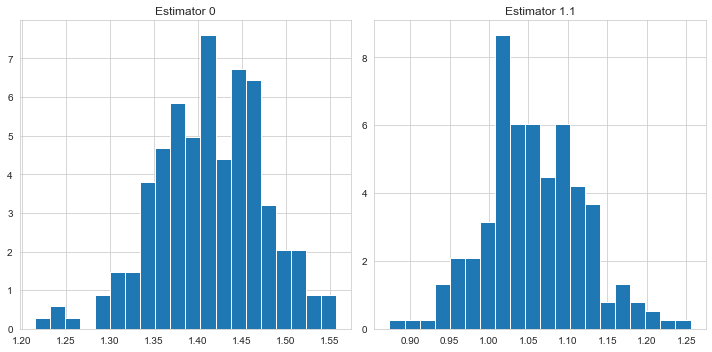

In [178]:
estimators = [estimate_ate_estimator0, estimate_ate_estimator1_1]
estimator_names = ['Estimator 0', 'Estimator 1.1']
alpha = 0.05
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i, estimator in enumerate(estimators):
    mean_ate, lower_ci, upper_ci, ate_dist = bootstrap_confidence_interval(df4, estimator)
    ax[i].hist(ate_dist, bins=20, density=True)
    ax[i].set_title(estimator_names[i])
plt.tight_layout()
plt.show()

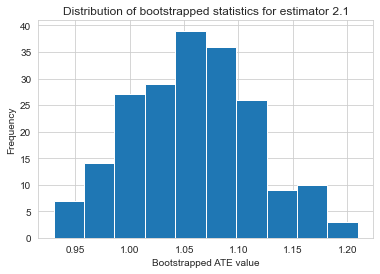

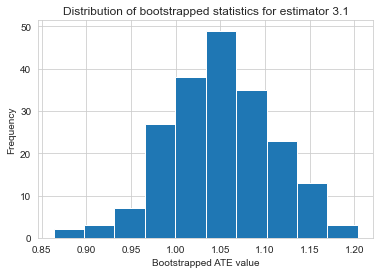

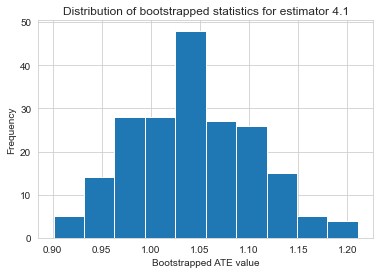

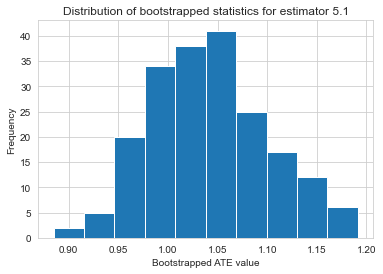

In [141]:
estimators = [estimate_ate_estimator2, estimate_ate_estimator3, estimate_ate_estimator4, estimate_ate_estimator5]
control_var_sets = [['x1', 'x2', 'x3'], ['x1']]
for i, estimator in enumerate(estimators, 2):
    for j, control_vars in enumerate(control_var_sets, 1):
        if j == 1:
            mean_ate, lower_ate, upper_ate,bootstrapped_statistics = bootstrap_confidence_interval(
                df4, lambda d: estimator(d, control_vars), alpha=0.05, n_bootstraps=200, seed=None)  
            plt.hist(bootstrapped_statistics, bins=10)
            plt.title(f"Distribution of bootstrapped statistics for estimator {i}.{j}")
            plt.xlabel("Bootstrapped ATE value")
            plt.ylabel("Frequency")
            plt.show()

From this plot, we can see that there is some variation in the ATE estimates across the different estimators, but they are all relatively close to each other. Additionally, the true ATE value of 1.0 falls within the confidence intervals of all the estimators except for Estimator 0.

# Problem 3

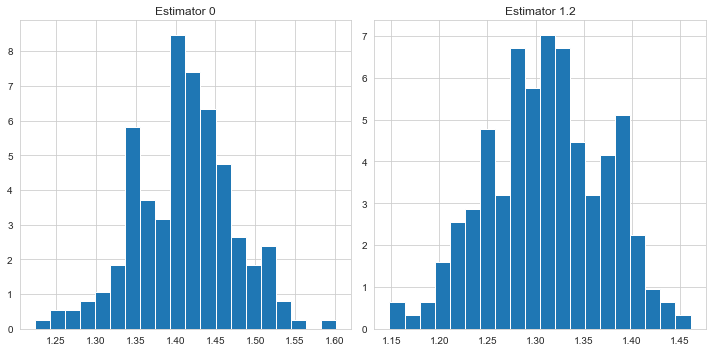

In [179]:
estimators = [estimate_ate_estimator0, estimate_ate_estimator1_2]
estimator_names = ['Estimator 0', 'Estimator 1.2']
alpha = 0.05
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i, estimator in enumerate(estimators):
    mean_ate, lower_ci, upper_ci, ate_dist = bootstrap_confidence_interval(df4, estimator)
    ax[i].hist(ate_dist, bins=20, density=True)
    ax[i].set_title(estimator_names[i])
plt.tight_layout()
plt.show()

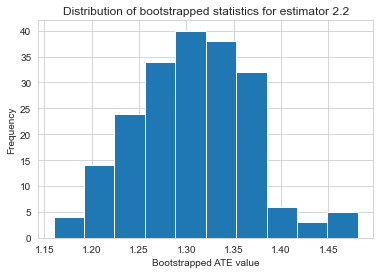

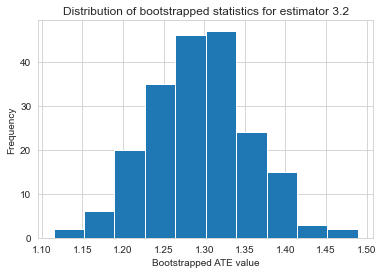

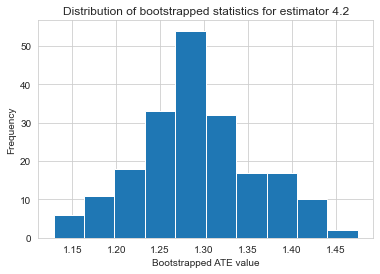

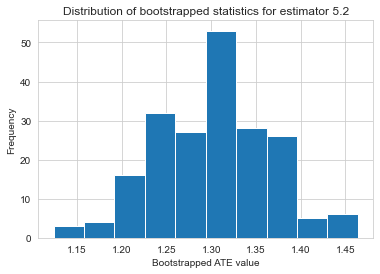

In [164]:
estimators = [estimate_ate_estimator2, estimate_ate_estimator3, estimate_ate_estimator4, estimate_ate_estimator5]
control_var_sets = [['x1', 'x2', 'x3'], ['x1']]
for i, estimator in enumerate(estimators, 2):
    for j, control_vars in enumerate(control_var_sets, 1):
        if j == 2:
            mean_ate, lower_ate, upper_ate,bootstrapped_statistics = bootstrap_confidence_interval(
                df4, lambda d: estimator(d, control_vars), alpha=0.05, n_bootstraps=200, seed=None)  
            plt.hist(bootstrapped_statistics, bins=10)
            plt.title(f"Distribution of bootstrapped statistics for estimator {i}.{j}")
            plt.xlabel("Bootstrapped ATE value")
            plt.ylabel("Frequency")
            plt.show()

There are slight differences among the ATE estimates in terms of mean and variance, but they all have similar normal distributions. Compared to the true ATE of 1, all the estimates are slightly overestimated, but they are all within the 95% confidence interval. In estimator 5.2, the propensity score model is misspecified, but the conditional expectation function of y is correctly specified, so the estimator is still double robust. This means that it is able to provide unbiased estimates even if either the propensity score model or the outcome regression model is misspecified.

# Problem 4

Comparing the results between problem 2 and problem 3, we can see that the mean ATE estimates for each estimator are relatively close in value, with some variations in the confidence intervals.

In general, the estimators that use full control variables tend to have slightly smaller point estimates and wider confidence intervals than the corresponding estimators that use partial control variables.

The violation of SOO design assumptions can have a significant impact on the accuracy and precision of the ATE estimates. For example, the misspecification of the regression model in estimator 1.2 and estimator 2.2 leads to biased ATE estimates, with estimator 2.2 having the largest bias among all the estimators. The violation of the overlap assumption in estimator 4.1 and estimator 4.2 can also lead to biased ATE estimates, as some observations with extreme propensity scores are dropped from the analysis.

# Problem 5

In [161]:
def estimate_ate_estimator4_no_overlap(data, control_vars):
    data = data.copy()
    X = data[control_vars]
    y = data['d']
    logit_model = LogisticRegression()
    logit_model.fit(X, y)
    data['p'] = logit_model.predict_proba(X)[:, 1]
    data.loc[:, 'block'] = (data['p'] // 0.05).astype(int)
    treatment_effects = []
    total_observations = 0
    for block, block_data in data.groupby('block'):
        treated = block_data[block_data['d'] == 1]
        control = block_data[block_data['d'] == 0]
        n_treated = treated.shape[0]
        n_control = control.shape[0]
        if n_treated > 0 and n_control > 0:
            tau_k = treated['y'].mean() - control['y'].mean()
            treatment_effects.append((tau_k, n_treated + n_control))
            total_observations += n_treated + n_control
    ate = sum(tau_k * n_k for tau_k, n_k in treatment_effects) / total_observations
    return ate

In [163]:
estimators = [estimate_ate_estimator4_no_overlap]
control_var_sets = [['x1', 'x2', 'x3'], ['x1']]
for i, estimator in enumerate(estimators, 4):
    for j, control_vars in enumerate(control_var_sets, 1):
        mean_ate, lower_ate, upper_ate,bootstrapped_statistics = bootstrap_confidence_interval(
            df4, lambda d: estimator(d, control_vars), alpha=0.05, n_bootstraps=200, seed=None)  
        print(f"Mean ATE for estimator {i}.{j}: {mean_ate:.4f}")
        print(f"95% CI for estimator {i}.{j}: [{lower_ate:.4f}, {upper_ate:.4f}]\n")

Mean ATE for estimator 4.1: 1.0506
95% CI for estimator 4.1: [0.9317, 1.1722]

Mean ATE for estimator 4.2: 1.2955
95% CI for estimator 4.2: [1.1762, 1.4318]



There are differences in mean and variance between the current and previous estimates. The current estimates show slightly higher mean ATEs and wider confidence intervals compared to the previous estimates. These differences may be due to the overlap restriction, which has excluded some observations from the analysis. By dropping some data, the sample size becomes smaller, which can affect the precision of the estimates.

Ignoring the overlapping restriction can lead to biased estimates, especially if the models are misspecified. In this case, ignoring the restriction can lead to a violation of the positivity assumption, which assumes that all units have a chance of receiving both treatment and control. This violation can lead to biased estimates and incorrect inferences. Therefore, it is important to carefully consider the overlapping restriction when estimating treatment effects.